In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings

import cv2
from tqdm import tqdm

import glob
import random

from albumentations import (
    HorizontalFlip, VerticalFlip, ShiftScaleRotate, Transpose, ShiftScaleRotate,  HueSaturationValue,
    RandomResizedCrop, RandomBrightnessContrast, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, 
    CenterCrop, Resize
)
from albumentations.pytorch import ToTensorV2

import timm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler

from sklearn.metrics import accuracy_score

warnings.simplefilter("ignore")

from pandas.core.common import flatten

/home/cvision/.virtualenvs/torch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [57]:
def plot_results(train_acc, valid_acc, train_loss, valid_loss, nb_epochs):
    epochs = [i for i in range(nb_epochs)]
    
    train_loss = torch.stack(train_loss).cpu().detach().numpy() #train_loss is cuda tensor

    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(20, 10)
    
    ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
    ax[0].plot(epochs, valid_acc, 'ro-', label='Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    
    ax[1].plot(epochs, train_loss, 'go-', label='Training Loss')
    ax[1].plot(epochs, valid_loss, 'ro-', label='Validation Loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    
    plt.show()

In [58]:
class Config:
    CFG = {
        'img_size': 100,
        'tta': 3,
        'wd': 1e-6
    }

In [59]:
class Augments:
    """
    Contains Train, Validation and Testing Augments
    """
    train_augments = Compose([
            RandomResizedCrop(Config.CFG['img_size'], Config.CFG['img_size']),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            CoarseDropout(p=0.5),
            Cutout(p=0.5),
            ToTensorV2(p=1.0),
        ],p=1.)
    
    valid_augments = Compose([
            CenterCrop(Config.CFG['img_size'], Config.CFG['img_size'], p=1.),
            Resize(Config.CFG['img_size'], Config.CFG['img_size']),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)

In [60]:
class ResNetModel(nn.Module):
    """
    Model Class for ResNet Models
    """
    def __init__(self, num_classes=5, model_name='resnet18', pretrained=True):
        super(ResNetModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        
    def forward(self, x):
        x = self.model(x)
        return x

In [61]:
class LDCData(Dataset):
    def __init__(self, df, num_classes=5, is_train=True, augments=None, img_size=Config.CFG['img_size'], img_path="../input/cassava-leaf-disease-classification/train_images/"):
        super().__init__()
        self.df = df.sample(frac=1).reset_index(drop=True)
        self.num_classes = num_classes
        self.is_train = is_train
        self.augments = augments
        self.img_size = img_size
        self.img_path = img_path
        
        # Add the Right Image Path
        self.df['image_id'] = self.df['image_id'].apply(lambda x: os.path.join(self.img_path, x))
    
    def __getitem__(self, idx):
        # Read the image, Resize, convert to RGB from BGR
        img = cv2.imread(self.df['image_id'][idx])
        img = img[:, :, ::-1]
        
        # Augments must be albumentations
        if self.augments:
            img = self.augments(image=img)['image']
        
        if self.is_train:
            label = self.df['label'][idx]
            return img, label
        
        return img
    
    def __len__(self):
        return len(self.df)

In [62]:
class Utils:
    def __init__(self, train_data_path, val_data_path):
        self.train_data_path = train_data_path 
        self.val_data_path = val_data_path 

        self.train_image_paths = []
        self.val_image_paths = []
        self.classes = []

    def get_image_path(self):
        for data_path in glob.glob(self.train_data_path + '/*'):
            self.classes.append(data_path.split('/')[-1])
            self.train_image_paths.append(glob.glob(data_path + '/*'))

        self.train_image_paths = list(flatten(self.train_image_paths))
        random.shuffle(self.train_image_paths)

        print('train_image_path example: ', self.train_image_paths[0])
        print('class example: ', self.classes[0])

        # val
        for data_path in glob.glob(self.val_data_path + '/*'):
            self.val_image_paths.append(glob.glob(data_path + '/*'))

        self.val_image_paths = list(flatten(self.val_image_paths))

        print("Train size: {}\nVal size: {}".format(len(self.train_image_paths), len(self.val_image_paths)))
        
        return self.train_image_paths, self.val_image_paths
    
    def idx_to_class(self):
        return {i:j for i, j in enumerate(self.classes)}
    
    def class_to_idx(self):
        return {value:key for key,value in self.idx_to_class().items()}
    

train_data_path = 'dataset/train'
val_data_path = 'dataset/val'

train_image_paths = []
classes = []

for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('/')[-1])
    train_image_paths.append(glob.glob(data_path + '/*'))

train_image_paths = list(flatten(train_image_paths))
random.shuffle(train_image_paths)

print('train_image_path example: ', train_image_paths[0])
print('class example: ', classes[0])

# train_image_paths, valid_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[int(0.8*len(train_image_paths)):]

# test
val_image_paths = []
for data_path in glob.glob(val_data_path + '/*'):
    val_image_paths.append(glob.glob(data_path + '/*'))

val_image_paths = list(flatten(val_image_paths))

print("Train size: {}\nVal size: {}".format(len(train_image_paths), len(val_image_paths)))

idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}


In [63]:
class FlowerDataset(Dataset):
    def __init__(self, image_paths, class_to_idx, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        self.class_to_idx = class_to_idx
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = image_filepath.split('/')[-2]
        label = self.class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image=image)["image"]

        return image, label

In [64]:
# nb_epochs = 20
# device = torch.device("cuda")

In [65]:
class Trainer:
    def __init__(self, train_dataloader, valid_dataloader, model, optimizer, loss_fn, val_loss_fn, scheduler, device="cuda:0", plot_results=True):
        """
        TODO: Implement the ROC-AUC Scheduler stuff
        """
        self.train = train_dataloader
        self.valid = valid_dataloader
        self.optim = optimizer
        self.loss_fn = loss_fn
        self.val_loss_fn = val_loss_fn
        self.scheduler = scheduler
        self.device = device
        self.plot_results = plot_results
        self.model = model 
        self.device = device
    def train_one_cycle(self):
        """
        Runs one epoch of training, backpropagation, optimization and gets train accuracy
        """
        self.model.train()
        train_prog_bar = tqdm(self.train, total=len(self.train))

        all_train_labels = []
        all_train_preds = []
        
        running_loss = 0
        scaler = GradScaler()
        
        for xtrain, ytrain in train_prog_bar:
            xtrain = xtrain.to(self.device).float()
            ytrain = ytrain.to(self.device).long()
            
            with autocast():
                # Get predictions
                z = self.model(xtrain)

                # Training
                train_loss = self.loss_fn(z, ytrain)
                scaler.scale(train_loss).backward()
                
                scaler.step(self.optim)
                scaler.update()
                self.optim.zero_grad()

                # For averaging and reporting later
                running_loss += train_loss

                # Convert the predictions and corresponding labels to right form
                train_predictions = torch.argmax(z, 1).detach().cpu().numpy()
                train_labels = ytrain.detach().cpu().numpy()

                # Append current predictions and current labels to a list
                all_train_labels += [train_predictions]
                all_train_preds += [train_labels]

            # Show the current loss to the progress bar
            train_pbar_desc = f'loss: {train_loss.item():.4f}'
            train_prog_bar.set_description(desc=train_pbar_desc)
        
        # After all the batches are done, calculate the training accuracy
        all_train_preds = np.concatenate(all_train_preds)
        all_train_labels = np.concatenate(all_train_labels)
        
        train_acc = (all_train_preds == all_train_labels).mean()
        print(f"Training Accuracy: {train_acc:.4f}")
        
        # Now average the running loss over all batches and return
        train_running_loss = running_loss / len(self.train)
        
        # Free up memory
        del all_train_labels, all_train_preds, train_predictions, train_labels, xtrain, ytrain, z
        
        return (train_acc, train_running_loss)

    def valid_one_cycle(self):
        """
        Runs one epoch of prediction and validation accuracy calculation
        """        
        self.model.eval()
        
        valid_prog_bar = tqdm(self.valid, total=len(self.valid))
        
        with torch.no_grad():
            all_valid_labels = []
            all_valid_preds = []
            
            running_loss = 0
            
            for xval, yval in valid_prog_bar:
                xval = xval.to(self.device).float()
                yval = yval.to(self.device).long()
                
                val_z = self.model(xval)
                
                val_loss = self.val_loss_fn(val_z, yval)
                
                running_loss += val_loss.item()
                
                val_pred = torch.argmax(val_z, 1).detach().cpu().numpy()
                val_label = yval.detach().cpu().numpy()
                
                all_valid_labels += [val_label]
                all_valid_preds += [val_pred]
            
                # Show the current loss
                valid_pbar_desc = f"loss: {val_loss.item():.4f}"
                valid_prog_bar.set_description(desc=valid_pbar_desc)
            
            # Get the final loss
            final_loss_val = running_loss / len(self.valid)
            
            # Get Validation Accuracy
            all_valid_labels = np.concatenate(all_valid_labels)
            all_valid_preds = np.concatenate(all_valid_preds)
            
            val_accuracy = (all_valid_preds == all_valid_labels).mean()
            print(f"Validation Accuracy: {val_accuracy:.4f}")
            
            # Free up memory
            del all_valid_labels, all_valid_preds, val_label, val_pred, xval, yval, val_z
            
        return (val_accuracy, final_loss_val, self.model)
    
    def fit(self, epochs: int = 10, output_dir: str = "/kaggle/working/", custom_name: str = 'model.pth'):
        best_loss = int(1e+7)
        # best_preds = None

        train_accs = []
        valid_accs = []
        train_losses = []
        valid_losses = []
        for epoch in range(epochs):
            print(f"{'-'*20} EPOCH: {epoch}/{epochs} {'-'*20}")

            # Run one training epoch
            current_train_acc, current_train_loss = self.train_one_cycle()
            train_accs.append(current_train_acc)
            train_losses.append(current_train_loss)

            # Run one validation epoch
            current_val_acc, current_val_loss, op_model = self.valid_one_cycle()
            valid_accs.append(current_val_acc)
            valid_losses.append(current_val_loss)

            if current_val_acc < best_loss:
                best_loss = current_val_acc
                self.save_model(output_dir, custom_name)
                print(f"Saved model with val_loss: {best_loss:.4f}")
        # Empty CUDA cache
        torch.cuda.empty_cache()
        plot_results(train_accs, valid_accs, train_losses, valid_losses, epochs)
        return best_loss
            
    def save_model(self, path, name, verbose=False):
        """
        Saves the model at the provided destination
        """
        try:
            if not os.path.exists(path):
                os.makedirs(path)
        except:
            print("Errors encountered while making the output directory")

        torch.save(self.model.state_dict(), os.path.join(path, name))
        if verbose:
            print(f"Model Saved at: {os.path.join(path, name)}")

[INFO] Using GPU: NVIDIA GeForce RTX 2070 with Max-Q Design

train_image_path example:  dataset/train/tulips/5653364300_bc557236c7_n.jpg
class example:  tulips
Train size: 3303
Val size: 367
-------------------- EPOCH: 0/5 --------------------


loss: 1.2155: 100%|██████████| 207/207 [00:08<00:00, 25.20it/s]


Training Accuracy: 0.4983


loss: 0.8966: 100%|██████████| 12/12 [00:00<00:00, 15.22it/s]


Validation Accuracy: 0.6485
Saved model with val_loss: 0.6485
-------------------- EPOCH: 1/5 --------------------


loss: 0.9216: 100%|██████████| 207/207 [00:07<00:00, 26.03it/s]


Training Accuracy: 0.6833


loss: 0.5860: 100%|██████████| 12/12 [00:00<00:00, 14.00it/s]


Validation Accuracy: 0.7057
-------------------- EPOCH: 2/5 --------------------


loss: 1.0502: 100%|██████████| 207/207 [00:08<00:00, 24.58it/s]


Training Accuracy: 0.7269


loss: 0.5314: 100%|██████████| 12/12 [00:00<00:00, 14.66it/s]


Validation Accuracy: 0.7493
-------------------- EPOCH: 3/5 --------------------


loss: 0.6779: 100%|██████████| 207/207 [00:08<00:00, 25.87it/s]


Training Accuracy: 0.7484


loss: 0.6087: 100%|██████████| 12/12 [00:00<00:00, 14.12it/s]


Validation Accuracy: 0.7657
-------------------- EPOCH: 4/5 --------------------


loss: 1.3985: 100%|██████████| 207/207 [00:08<00:00, 25.60it/s]


Training Accuracy: 0.7602


loss: 0.6709: 100%|██████████| 12/12 [00:00<00:00, 13.98it/s]


Validation Accuracy: 0.7956


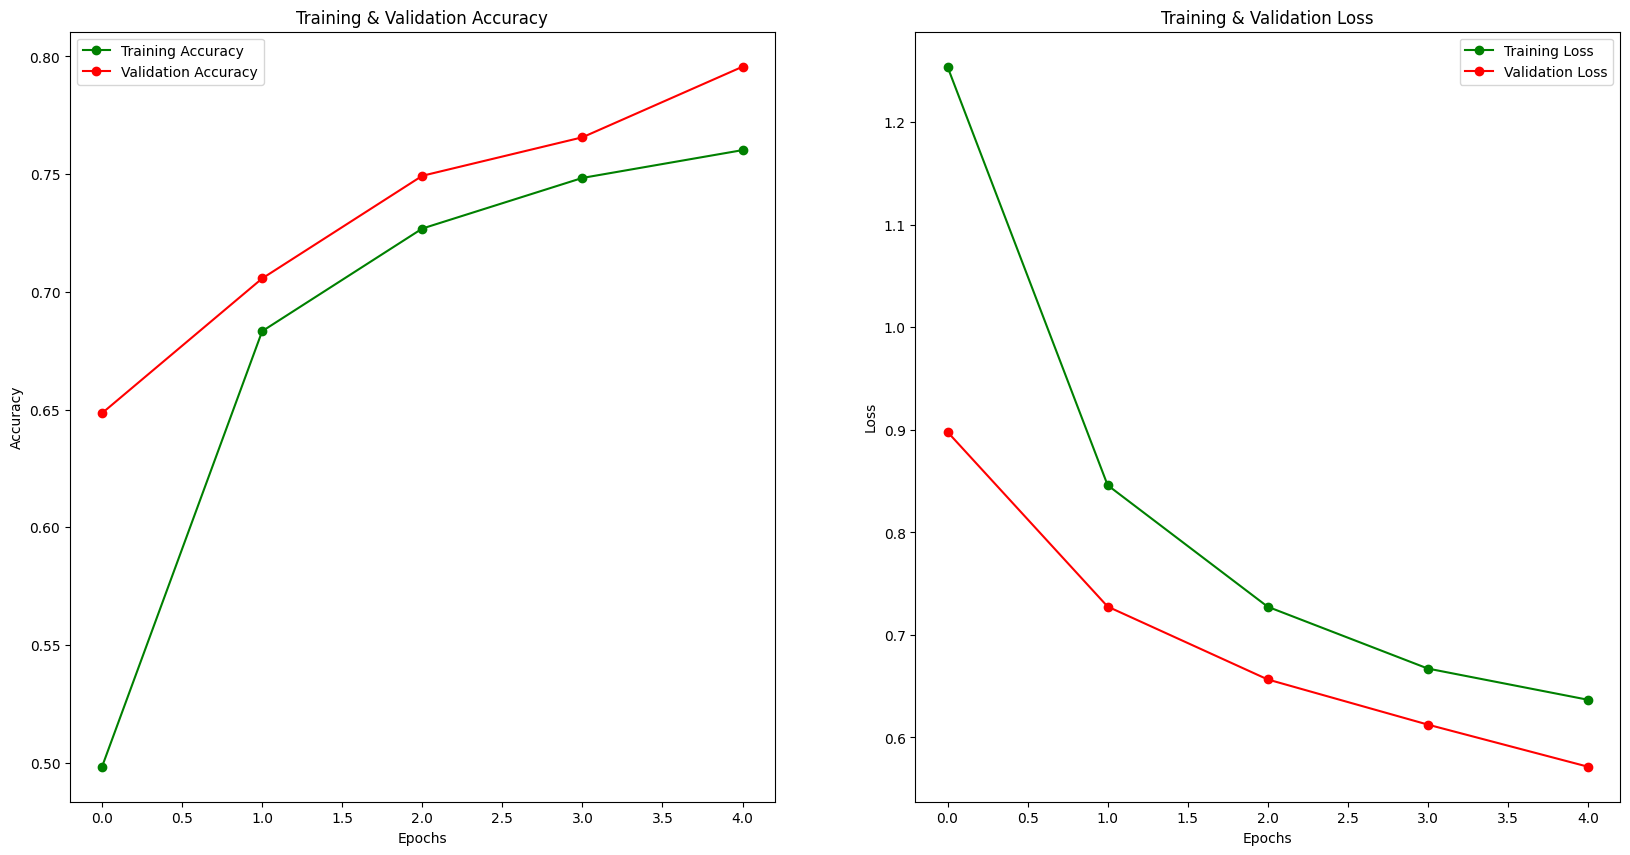

In [66]:
if __name__ == '__main__':
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
        DEVICE = torch.device('cuda:0')
    else:
        print("\n[INFO] GPU not found. Using CPU: {}\n".format(platform.processor()))
        DEVICE = torch.device('cpu')
    utils = Utils(
        'dataset/train',
        'dataset/val'
    )

    train_image_paths, val_image_paths = utils.get_image_path()
    train_set = FlowerDataset(train_image_paths, utils.class_to_idx(), Augments.train_augments)
    valid_set = FlowerDataset(val_image_paths, utils.class_to_idx(),Augments.valid_augments)


    train = DataLoader(
        train_set,
        batch_size=16,
        shuffle=True,
        pin_memory=False,
        drop_last=False,
        num_workers=8
    )

    valid = DataLoader(
        valid_set,
        batch_size=32,
        shuffle=False,
        pin_memory=False,
        num_workers=8
    )

    model = ResNetModel(num_classes=5).to(DEVICE)
    optim = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=Config.CFG['wd'])
    loss_fn = nn.CrossEntropyLoss().to(DEVICE)
    loss_fn_val = nn.CrossEntropyLoss().to(DEVICE)

    trainer = Trainer(
        train_dataloader=train,
        valid_dataloader=valid,
        model=model,
        optimizer=optim,
        loss_fn=loss_fn,
        val_loss_fn=loss_fn_val,
        scheduler=None,
        device=DEVICE,
    )

    trainer.fit(
        epochs=5,
        output_dir='output',
        custom_name="model.pth"
    )

    # train_accs = []
    # valid_accs = []
    # train_losses = []
    # valid_losses = []

    # scaler = GradScaler()

    # for epoch in range(nb_epochs):
    #     print(f"{'-'*20} EPOCH: {epoch}/{nb_epochs} {'-'*20}")

    #     # Run one training epoch
    #     current_train_acc, current_train_loss = trainer.train_one_cycle()
    #     train_accs.append(current_train_acc)
    #     train_losses.append(current_train_loss)

    #     # Run one validation epoch
    #     current_val_acc, current_val_loss, op_model = trainer.valid_one_cycle()
    #     valid_accs.append(current_val_acc)
    #     valid_losses.append(current_val_loss)

    #     # Empty CUDA cache
    #     torch.cuda.empty_cache()
        
    #     # Save the model every epoch
    #     print(f"Saving Model for this epoch...")
    #     torch.save(op_model.state_dict(), f"vit_base_p16_384_fold_{fold}_model.pth")
    
    del train_set, valid_set, train, valid, model, optim, loss_fn, loss_fn_val, trainer
    torch.cuda.empty_cache()
